In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2Model

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

print(model)
print(f"Device: {model.device}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)
Device: cpu


In [3]:
!pip install --upgrade datasets

In [4]:
from google.colab import drive
drive.mount('/content/drive')



# load the datasets from the Google Drive .csv file
from datasets import load_dataset
train_dataset = load_dataset('csv', data_files='/content/drive/MyDrive/ai-laboratory/Natural Disaster Tweets/train.csv')['train']
test_dataset = load_dataset('csv', data_files='/content/drive/MyDrive/ai-laboratory/Natural Disaster Tweets/test.csv')['train']


print("Train Dataset")
print(train_dataset)
print(train_dataset[0])
print("\n\n\n\n")


print("Test Dataset")
print(test_dataset)
print(test_dataset[0])


Mounted at /content/drive


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Train Dataset
Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target'],
    num_rows: 7613
})
{'id': 1, 'keyword': None, 'location': None, 'text': 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all', 'target': 1}





Test Dataset
Dataset({
    features: ['id', 'keyword', 'location', 'text'],
    num_rows: 3263
})
{'id': 0, 'keyword': None, 'location': None, 'text': 'Just happened a terrible car crash'}


In [5]:
# taking the tokenizer for a spin
texts = ["hello gpt-2!", "bye gpt-2, you are pretty cool"]
tokenizer.pad_token = tokenizer.eos_token
encoded_inputs = tokenizer(texts, padding=True)

print(encoded_inputs)

print("Sequence 1")
print(tokenizer.decode(encoded_inputs.input_ids[0]))


print("Sequence 2")
print(tokenizer.decode(encoded_inputs.input_ids[1]))

{'input_ids': [[31373, 308, 457, 12, 17, 0, 50256, 50256, 50256, 50256], [16390, 308, 457, 12, 17, 11, 345, 389, 2495, 3608]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}
Sequence 1
hello gpt-2!<|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Sequence 2
bye gpt-2, you are pretty cool


In [6]:
# add a special extract token (following the classification setup in GPT-2 paper)
# https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf

print(f"original vocabulary size: {len(tokenizer)}")
num_added_toks = tokenizer.add_tokens("<|extract|>")
print(f"The new vocabulary size is {len(tokenizer)}")

# also, resize the model embeddings
model.resize_token_embeddings(len(tokenizer))


# log the new output matrix size
print(f"New embedding shape: {model.get_input_embeddings().weight.shape}")

original vocabulary size: 50257
The new vocabulary size is 50258


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


New embedding shape: torch.Size([50258, 768])


In [7]:
# get the token_id of the new token we just added
extract_tok_id = tokenizer.encode("<|extract|>")[0]

In [8]:
x = torch.tensor([2])
print(x.shape)

torch.Size([1])


In [9]:
def custom_collate_fn(batch, split):
  # get the id's
  ids = [item['id'] for item in batch]

  # get the texts
  texts = [item['text'] for item in batch]

  # tokenizer the inputs
  tokenizer.padding_side = 'left'
  tokenizer.pad_token = tokenizer.eos_token
  encoded_inputs = tokenizer(texts, padding=True, return_tensors="pt")

  input_ids = encoded_inputs.input_ids
  attention_mask = encoded_inputs.attention_mask

  labels = None
  # get the labels if we're in training mode (targets not available in test)
  if split == 'train':
    labels = [item['target'] for item in batch]


  batch_size = input_ids.size(0)
  # concatenate the <|extract|> token we just added
  extract_column = torch.full((batch_size, 1),
                              extract_tok_id,
                              dtype=input_ids.dtype,
                              device=input_ids.device)

  ones_column = torch.ones((batch_size, 1), dtype=attention_mask.dtype)

  input_ids = torch.cat([input_ids, extract_column], dim=1)
  attention_mask = torch.cat([attention_mask, ones_column], dim=1)

  return {
      "input_ids": input_ids,
      "attention_mask": attention_mask,
      "labels": labels,
      "ids": ids
  }

In [10]:
from torch.utils.data import DataLoader
from functools import partial

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=4, collate_fn = partial(custom_collate_fn, split="train"))

for batch in train_loader:
  print(batch)
  print(batch['input_ids'].shape)
  break

{'input_ids': tensor([[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
            31,  2782,  2178, 11848, 11752,   326,   338,   407,  1165,  2089,
           788, 42254,    13,   314,   561,  1053,   587,  3425,  7958, 42796,
            13, 50257],
        [50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256,    40,  5839,   257,  5598,
          8590, 17379,   286, 26636,  9215,   290,   340,   338,   655,  1972,
         33359, 50257],
        [13434,  6615,   866,   625, 29957,   319, 20145, 14914,    13,  6251,
          9302,   423,   655,   587, 23724,  2488,    24,  9980,    33,  2442,
         20235,  2488,    24,  9980, 13306,  7222,   459,  2638,  1378,    83,
            13,  1073,    14,    42,    35,    18,    48,    82,   46

In [11]:
input_seq = batch['input_ids'][0].unsqueeze(0)
print(input_seq)
trimmed_input_seq = input_seq[:, 8:]
print(trimmed_input_seq)
# taking the model for a spin
print(trimmed_input_seq.shape)


outputs = model(trimmed_input_seq)
print(outputs.keys())
print(outputs.last_hidden_state.shape) # (1, seq_length, vocab_size)

tensor([[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
            31,  2782,  2178, 11848, 11752,   326,   338,   407,  1165,  2089,
           788, 42254,    13,   314,   561,  1053,   587,  3425,  7958, 42796,
            13, 50257]])
tensor([[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256,    31,  2782,  2178, 11848, 11752,   326,   338,   407,
          1165,  2089,   788, 42254,    13,   314,   561,  1053,   587,  3425,
          7958, 42796,    13, 50257]])
torch.Size([1, 34])
odict_keys(['last_hidden_state', 'past_key_values'])
torch.Size([1, 34, 768])


In [24]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class GPTClassifier(nn.Module):

  def __init__(self, base_model):
    super().__init__()
    self.base_model = base_model
    self.fc1 = nn.Linear(768, 100)
    self.fc2 = nn.Linear(100, 1)

  def forward(self, x, attention_mask, targets=None):
    logits = self.base_model(x, attention_mask=attention_mask)['last_hidden_state'] # (B, T, C)

    last_tok_logits = logits[:, -1, :] # pluck out the tokens corresponding to the last position in the sequence (the extract token we added)


    hidden = self.fc1(last_tok_logits)
    hidden = F.relu(hidden)
    logits = self.fc2(hidden)

    # print(logits.shape)

    loss = None
    if targets is not None:
      loss = F.binary_cross_entropy_with_logits(logits, targets)

    return logits, loss



In [25]:
classifier = GPTClassifier(base_model=model)
print(classifier)

GPTClassifier(
  (base_model): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (fc1): Linear(in_features=768, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


In [26]:
# test forward pass
x = batch['input_ids']
attention_mask = batch['attention_mask']
targets = torch.tensor(batch['labels'], dtype=torch.float32)
targets = targets.view(targets.size(0), -1)

classifier(x, attention_mask, targets)

TypeError: must be real number, not NoneType

# Training Loop

In [28]:
# training loop
classifier = GPTClassifier(base_model = model)
if torch.cuda.is_available():
  classifier.to('cuda')
learning_rate = 1e-5
num_epochs = 2
iter_counter = 0
batch_size = 16
print_every = 50

In [29]:
import torch.optim as optim
optimizer = optim.Adam(classifier.parameters(), lr = learning_rate)

In [30]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn = partial(custom_collate_fn, split="train"))

In [31]:
device = next(classifier.parameters()).device
print(device)

cuda:0


In [32]:
loss_history = []
model.train()

for epoch_idx in range(num_epochs):
  for batch_idx, batch in enumerate(train_loader):
    x = batch['input_ids']
    attention_mask = batch['attention_mask']

    targets = torch.tensor(batch['labels'], dtype=torch.float32)
    targets = targets.view(targets.size(0), -1)

    # move all tensors to the same
    x = x.to(device)
    attention_mask = attention_mask.to(device)
    targets = targets.to(device)

    logits, loss = classifier(x, attention_mask, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter_counter % print_every == 0:
      # calculate the number of accurate predictions
      preds = torch.where(logits > 0, 1, 0)
      num_correct = (preds == targets).to(torch.long).sum()
      total = preds.size(0)

      print(f"Iteration: {iter_counter}, Loss: {loss.item()}, Accuracy: {num_correct/total}")

    loss_history.append(loss.item())
    iter_counter += 1

Iteration: 0, Loss: 0.7074631452560425, Accuracy: 0.5
Iteration: 50, Loss: 0.7535156011581421, Accuracy: 0.625
Iteration: 100, Loss: 0.4498656392097473, Accuracy: 0.75
Iteration: 150, Loss: 0.4095040261745453, Accuracy: 0.875
Iteration: 200, Loss: 0.39200395345687866, Accuracy: 0.875
Iteration: 250, Loss: 0.3834470808506012, Accuracy: 0.875
Iteration: 300, Loss: 0.40989840030670166, Accuracy: 0.8125
Iteration: 350, Loss: 0.44903531670570374, Accuracy: 0.75
Iteration: 400, Loss: 0.5554913878440857, Accuracy: 0.75
Iteration: 450, Loss: 0.3529096841812134, Accuracy: 0.875
Iteration: 500, Loss: 0.4085542559623718, Accuracy: 0.8125
Iteration: 550, Loss: 0.21106354892253876, Accuracy: 0.9375
Iteration: 600, Loss: 0.42815184593200684, Accuracy: 0.875
Iteration: 650, Loss: 0.3106488287448883, Accuracy: 0.875
Iteration: 700, Loss: 0.5742009878158569, Accuracy: 0.6875
Iteration: 750, Loss: 0.37916356325149536, Accuracy: 0.875
Iteration: 800, Loss: 0.3259120583534241, Accuracy: 0.875
Iteration: 8

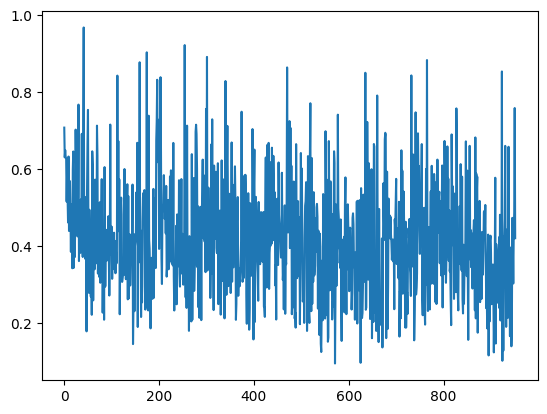

In [33]:
import matplotlib.pyplot as plt

plt.plot(loss_history)

# Evaluation Loop

In [34]:
from tqdm import tqdm

batch_size = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=partial(custom_collate_fn, split="test"))

all_ids = []
predictions = []


for batch_idx, batch in tqdm(enumerate(test_loader)):
  x = batch['input_ids']
  attention_mask = batch['attention_mask']

  ids = batch['ids']

  x = x.to(device)
  attention_mask = attention_mask.to(device)

  logits, _ = classifier(x, attention_mask)

  preds = torch.where(logits > 0, 1, 0)

  all_ids.extend(ids)
  predictions.extend(preds.squeeze().tolist())

204it [00:11, 18.22it/s]


In [35]:
print(all_ids)
print(predictions)

[0, 2, 3, 9, 11, 12, 21, 22, 27, 29, 30, 35, 42, 43, 45, 46, 47, 51, 58, 60, 69, 70, 72, 75, 84, 87, 88, 90, 94, 99, 101, 103, 106, 108, 111, 115, 116, 122, 123, 124, 125, 127, 140, 142, 147, 148, 150, 152, 154, 155, 166, 167, 169, 177, 179, 181, 186, 188, 189, 192, 200, 202, 206, 207, 214, 217, 223, 224, 227, 228, 230, 233, 234, 236, 239, 250, 255, 257, 259, 275, 278, 282, 284, 286, 288, 292, 295, 300, 304, 305, 306, 308, 311, 317, 319, 323, 324, 325, 326, 333, 339, 342, 343, 350, 351, 357, 359, 362, 366, 367, 369, 373, 374, 376, 377, 378, 379, 382, 385, 387, 388, 391, 392, 395, 399, 400, 403, 405, 408, 411, 414, 416, 417, 422, 425, 428, 430, 431, 433, 434, 439, 441, 449, 458, 460, 464, 473, 488, 491, 494, 497, 500, 505, 507, 508, 510, 511, 515, 525, 529, 532, 534, 537, 539, 541, 545, 547, 548, 549, 553, 554, 555, 557, 562, 566, 572, 573, 582, 586, 587, 590, 591, 593, 595, 596, 597, 601, 602, 605, 610, 616, 618, 620, 626, 627, 629, 632, 634, 639, 645, 647, 648, 650, 663, 666, 668, 670

In [36]:
# generate submission file

import pandas as pd

# Create a dictionary for the submission file
submission_dict = {
    'id': all_ids,
    'target': predictions
}

# Create a pandas DataFrame from the dictionary
submission_df = pd.DataFrame(submission_dict)

# Save the DataFrame to a CSV file
# The index=False argument is crucial to prevent pandas from writing an extra column
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")

Submission file 'submission.csv' created successfully!
